# Time Series Analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the fourth task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in time series analysis.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [422]:
#%%capture
#!python -m pip install --upgrade pip
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install seaborn
#!pip install sklearn
#!pip install tslearn
#!pip install matrixprofile

In [423]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matrixprofile import matrixProfile
# Añadir aqui las librerias que necesitamos importar

After importing the required libraries, we will read the datasets that we have exported in the task 1, which they contain the data filtered after the data preparation tasks.

In [424]:
# Load the dataset
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)
incidents_dataset_v2 = pd.read_csv('../project_datasets/incidents_v2.csv', low_memory=False)


## Time Series Analysis

Consider the incidents dataset and only incidents that happened in the years [2014,
2015, 2016, 2017]. Extract a time series for each city, computing for each week of the 4
years a score. The score can be an index created in one of the previous tasks or a new
one and it can be different for each subtask. Therefore, each value of the time series
(one for each city) corresponds to the score value for a certain week of 2014, 2015,
2016, 2017. You can filter the cities, excluding the ones with a low number of weeks with
incidents. For example, you can consider only cities with a number of weeks with
incidents greater than 15% of the total number of the weeks of the 4 years.

In [425]:
# Add the 'city_or_county' column to the main dataset (incidents_v3) modified in task 3
incidents_dataset['city_or_county'] = incidents_dataset_v2['city_or_county']

# Convert the 'year', 'month', and 'day' columns to a date format
incidents_dataset['date'] = pd.to_datetime(incidents_dataset[['year', 'month', 'day']], format='%Y%m%d')

# Add a new column 'week'
incidents_dataset['week'] = incidents_dataset['date'].dt.isocalendar().week

# Filter incidents for the years 2014 to 2017
filtered_incidents = incidents_dataset[(incidents_dataset['date'].dt.year >= 2014) & (incidents_dataset['date'].dt.year <= 2017)]

# Calculate the number of weeks with incidents for each city
weekly_counts = filtered_incidents.groupby(['city_or_county', 'week']).size().reset_index(name='incident_count')

# Calculate the total number of weeks in the 4 years
total_weeks = len(set(weekly_counts['week']))

# Calculate the minimum number of weeks required for inclusion (e.g., 15% of total weeks)
min_weeks_required = int(0.15 * total_weeks)

# Filter cities with incidents greater than the minimum number of required weeks
valid_cities = weekly_counts.groupby('city_or_county')['incident_count'].count() > min_weeks_required
valid_cities = valid_cities[valid_cities].index.tolist()

# Filter the dataset to include only valid cities
filtered_incidents = filtered_incidents[filtered_incidents['city_or_county'].isin(valid_cities)]

# Calculate a score for each city in each week based on the number of participants (n_participants).
# You can replace the following line with your specific scoring logic.
city_scores = filtered_incidents.groupby(['city_or_county', 'week'])['n_participants'].mean().reset_index(name='score')

# The 'city_scores' DataFrame now contains the time series for each city with the calculated scores.
print(city_scores)

      city_or_county  week  score
0          Abbeville     7    2.0
1          Abbeville     8    1.0
2          Abbeville    13    1.0
3          Abbeville    16    4.0
4          Abbeville    22    1.0
...              ...   ...    ...
36655           Zion    33    6.0
36656           Zion    35    1.0
36657           Zion    37    3.0
36658           Zion    41    2.0
36659           Zion    46    4.0

[36660 rows x 3 columns]


### Clustering and motif/anomalies extraction

The goal of this task is grouping similar cities through the use of the created time series,
based on the defined score. Analyze the results of the clustering and extract motifs and
anomalies in the time series for a deep understanding and exploration.

#### Clustering

First we prepare and make clustering of the data using the K-means clustering. We try diferent number of clusters and we compare their efficiency to find the best number of clusters for k-means.

In [426]:
# Pivot the DataFrame to have time series data for each city
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='score').fillna(0).values

# Normalize the time series data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(time_series_data)

# Reshape the data to make it 2D
num_cities, num_weeks = normalized_data.shape
flattened_data = normalized_data.reshape(num_cities, -1)

# Specify a range of cluster numbers to try
cluster_range = range(2, 11)  # You can adjust the range as needed

# Try different cluster numbers and evaluate their silhouette scores
best_score = -1
best_k = 2

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100, max_iter=3000, tol=1e-10)
    clusters = kmeans.fit_predict(flattened_data)
    silhouette_avg = silhouette_score(flattened_data, clusters)
    
    print(f'Clusters: {k}, Silhouette Score: {silhouette_avg}')
    
    # Update best results
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

# Apply K-means clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100, max_iter=1000, tol=1e-5)
clusters = kmeans.fit_predict(flattened_data)

# Create a DataFrame with the city names and corresponding cluster assignments
cluster_df = pd.DataFrame({'city_or_county': city_scores['city_or_county'].unique(), 'cluster': clusters})

# Merge the original DataFrame with the clustering results
city_scores = pd.merge(city_scores, cluster_df, on='city_or_county', how='left')

# Visualize the clustered cities or perform additional analysis
print(city_scores)

Clusters: 2, Silhouette Score: 0.2221899350893444
Clusters: 3, Silhouette Score: 0.15433388443608073
Clusters: 4, Silhouette Score: 0.09859482890561634
Clusters: 5, Silhouette Score: 0.06853156052700339
Clusters: 6, Silhouette Score: 0.06243168352315088
Clusters: 7, Silhouette Score: 0.04918289581982446
Clusters: 8, Silhouette Score: 0.031037439526297422
Clusters: 9, Silhouette Score: 0.006929887106479801
Clusters: 10, Silhouette Score: 0.04182373656889373
      city_or_county  week  score  cluster
0          Abbeville     7    2.0        1
1          Abbeville     8    1.0        1
2          Abbeville    13    1.0        1
3          Abbeville    16    4.0        1
4          Abbeville    22    1.0        1
...              ...   ...    ...      ...
36655           Zion    33    6.0        1
36656           Zion    35    1.0        1
36657           Zion    37    3.0        1
36658           Zion    41    2.0        1
36659           Zion    46    4.0        1

[36660 rows x 4 column

We can see that the best number is 2 clusters so we fit the data with that.

Then we plot the results to see and analyze it clearly. We can plot the diferent clusters into diferents graphs to see better their characteristics.

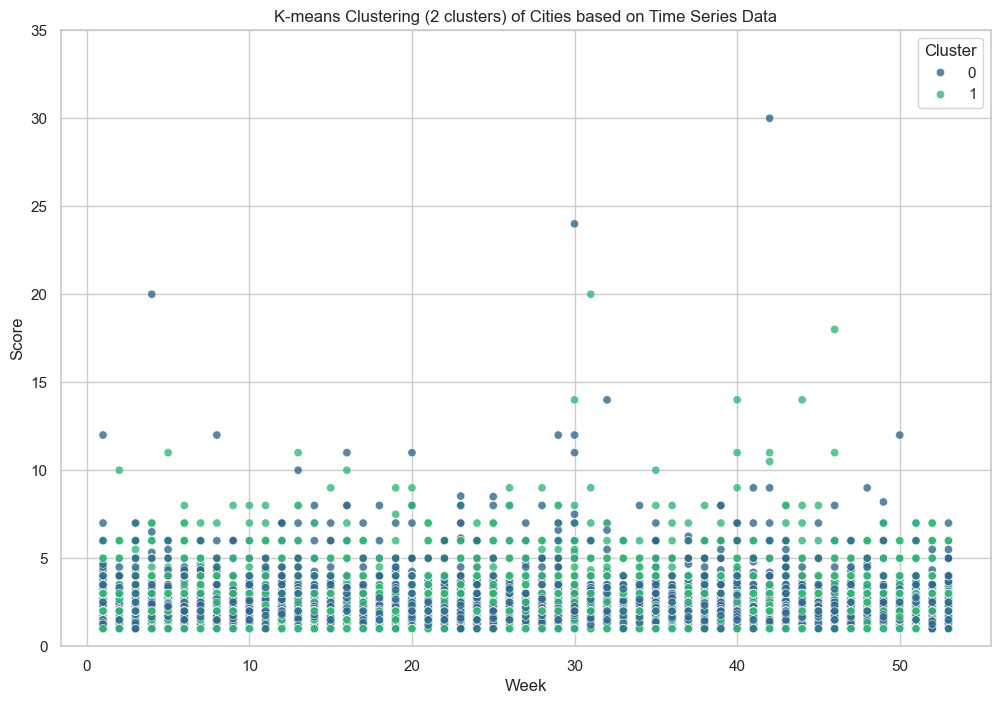

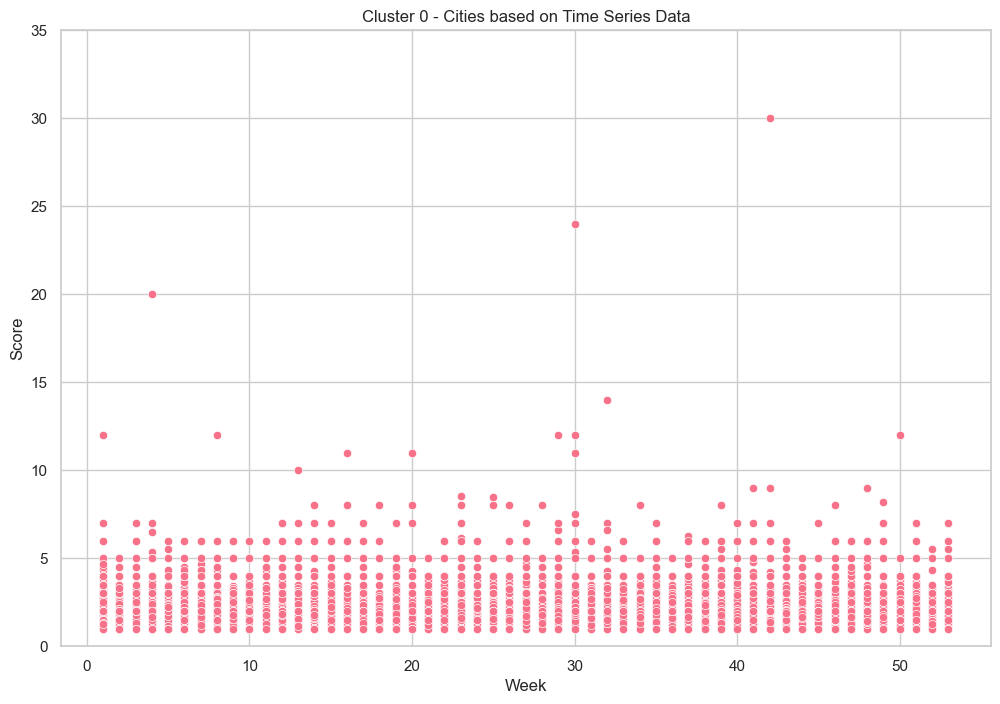

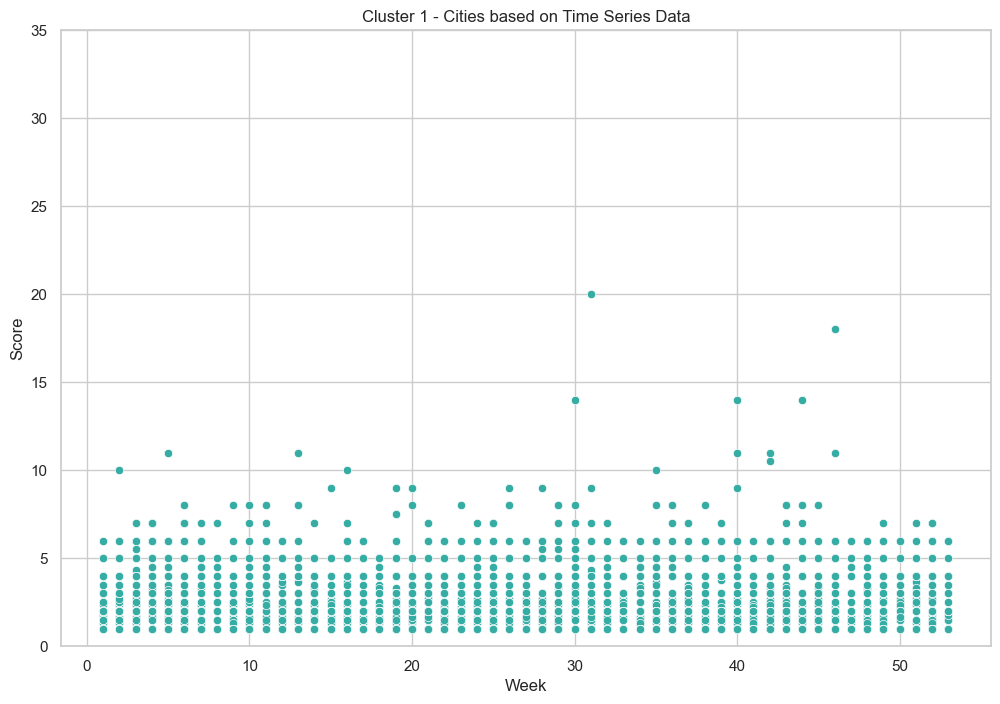

In [427]:
# Determine the maximum value on the x-axis for all visualizations
max_score_value = city_scores['score'].max() + 5

# Visualize the clustered cities with improved color palette and transparency
plt.figure(figsize=(12, 8))
sns.scatterplot(x='week', y='score', hue='cluster', data=city_scores, palette='viridis', legend='full', alpha=0.8, edgecolor='w')
plt.ylim(0, max_score_value)  # Set the limit on the y-axis
plt.xlabel('Week')
plt.ylabel('Score')
plt.title(f'K-means Clustering ({best_k} clusters) of Cities based on Time Series Data')
plt.legend(title='Cluster')
plt.show()

# Visualize each cluster separately
for cluster_num in range(best_k):
    # Filter the DataFrame for the current cluster
    cluster_data = city_scores[city_scores['cluster'] == cluster_num]

    # Create the scatter plot for the current cluster
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='week', y='score', data=cluster_data, color=cluster_palette[cluster_num], edgecolor='w')
    plt.ylim(0, max_score_value)  # Set the limit on the y-axis
    plt.xlabel('Week')
    plt.ylabel('Score')
    plt.title(f'Cluster {cluster_num} - Cities based on Time Series Data')

    # Show the plot
    plt.show()

This shows us that the two clusters hasn't a big diference. Cluster 0 has weeks with more score in average than cluster 1. The maximum score of cluster 0 is 30 while the one of cluster 1 is 20. There are not many differences in terms of weeks, this is because in general the number of incidents is widely distributed throughout the year, and there is no time that stands out, therefore when doing the clustering this has not occurred. For all this we can say that the only minimal notable difference is the score, giving cluster 0 an average score somewhat higher than that of cluster 1 and therefore a number of participants somewhat higher. We differentiate them by cluster 0 as the more average number of participants and cluster 1 as less average number of participants.

#### Motif and Anomalies

We have seen before that there is nothing strage to comment, but to be sure we will extract graphs of the average scores based on the two diferents parameters that we have, the weeks and the cities, and calculate if there is any motif or any anomaly we haven't seen.

##### Week based

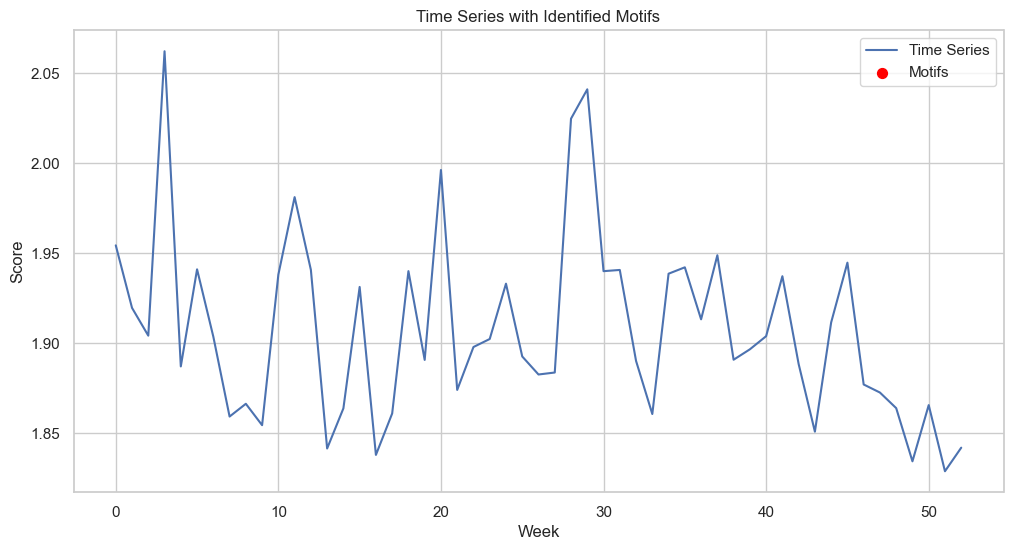

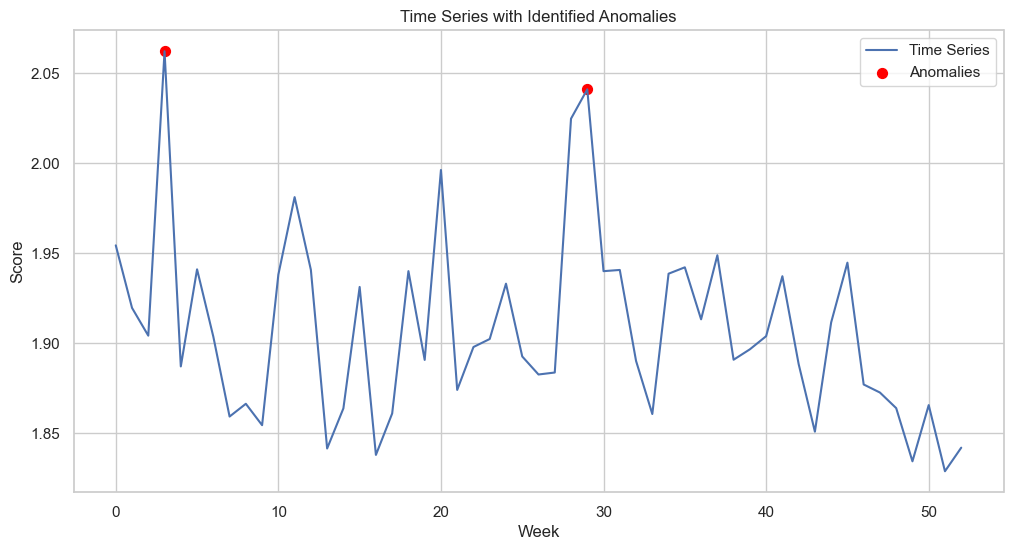

In [428]:
# Obtain the time series based on the 'week' column
time_series_data = city_scores.groupby('week')['score'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = matrixProfile.stomp(time_series_data, window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:-(window_size-1)])[:3] + window_size // 2

# Visualize the time series with identified motifs
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(motif_indices, time_series_data[motif_indices], color='red', label='Motifs', s=50)
plt.title('Time Series with Identified Motifs')
plt.xlabel('Week')
plt.ylabel('Score')
plt.legend()
plt.show()

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data - np.mean(time_series_data)) / np.std(time_series_data)

# Set a threshold to identify anomalies (adjust as needed)
anomaly_threshold = 2.5

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(anomaly_indices, time_series_data[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Anomalies')
plt.xlabel('Week')
plt.ylabel('Score')
plt.legend()
plt.show()

Based on the weeks we can se that the average score of every week is between 2 and 1.8, but there is two times where the score is bigger of two an that is near the 4th week and the other near the 29th week. The first anomaly occurs at the end of January, while the second in mid-July. This may be due to certain American holidays or special days that occur on those dates or some specific event that occurred and that triggered the number of participants in the accidents at those times. We see that there is no motif, that is a sequence that repeats itself clearly enough to affirm that it is a pattern, therefore it could be said that all the cases throughout the year are random and have no relation to the season of the year.

##### City_or_county based

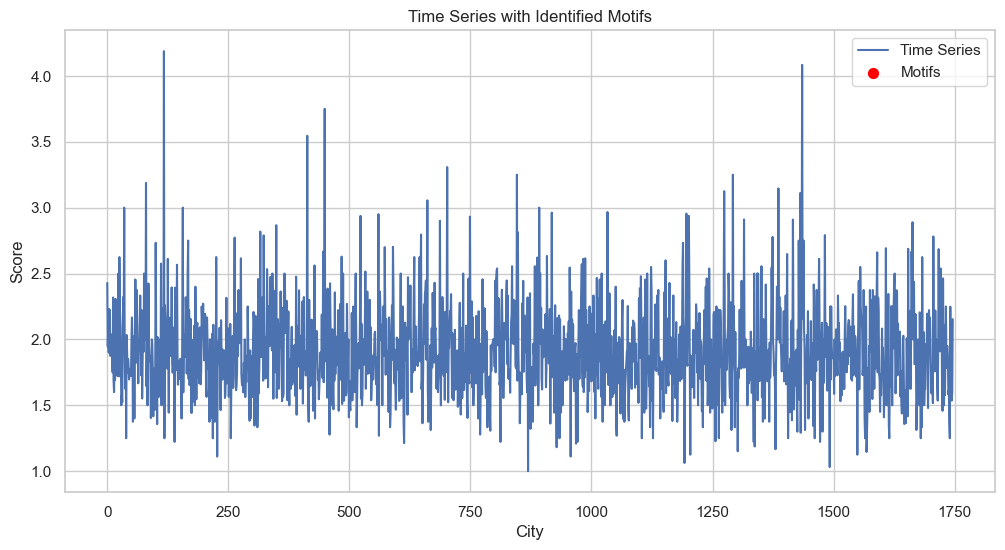

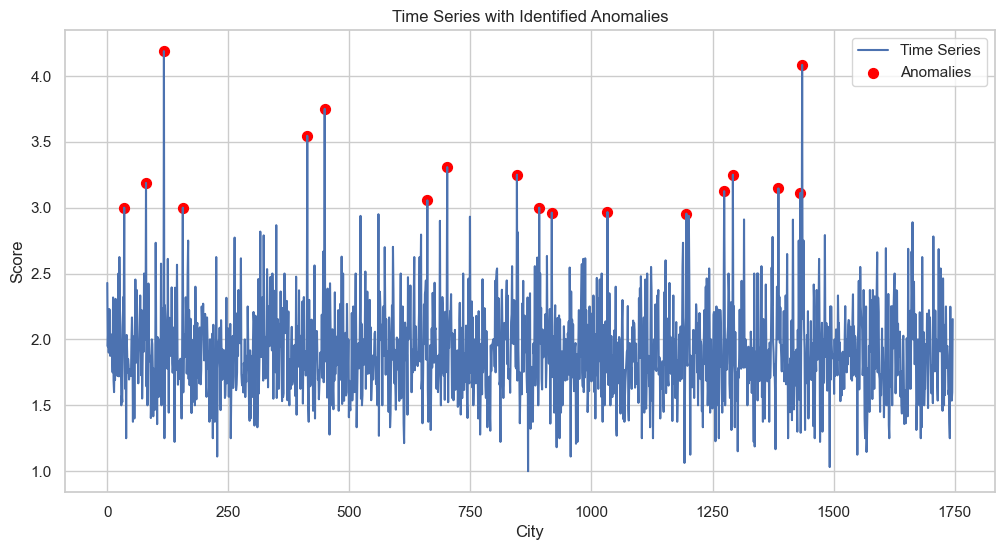

Cities with Anomalies: ['Aberdeen' 'Abingdon' 'Adrian' 'Aiken' 'Alexander City' 'Alexandria'
 'Amarillo' 'Anchorage' 'Anderson' 'Ann Arbor' 'Antioch' 'Arlington'
 'Asbury Park' 'Asheboro' 'Ashtabula' 'Athens']


In [429]:
# Obtain the time series based on the 'city_or_county' column
time_series_data = city_scores.groupby('city_or_county')['score'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = matrixProfile.stomp(time_series_data, window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:-(window_size-1)])[:3] + window_size // 2

# Visualize the time series with identified motifs
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(motif_indices, time_series_data[motif_indices], color='red', label='Motifs', s=50)
plt.title('Time Series with Identified Motifs')
plt.xlabel('City')
plt.ylabel('Score')
plt.legend()
plt.show()

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data - np.mean(time_series_data)) / np.std(time_series_data)

# Set a threshold to identify anomalies (adjust as needed)
anomaly_threshold = 3

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Time Series')
plt.scatter(anomaly_indices, time_series_data[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Anomalies')
plt.xlabel('City')
plt.ylabel('Score')
plt.legend()
plt.show()

# Extract the names of cities where anomalies occur
anomaly_cities = city_scores['city_or_county'].iloc[anomaly_indices].unique()

# Print the names of cities with anomalies
print("Cities with Anomalies:", anomaly_cities)

If we look by city instead of by week we can see that there is no clear pattern either and therefore we cannot say that there is a motif, which is why there is no relationship between the average number of participants between each city. Instead, we found several cities that could contain anomalies. This could be because at some point in the 4 years studied there was one or several incidents with a large number of people participating that triggered the numbers.

### Shapelet extraction

Exploiting the created time series, extract the shapelet according to the class of the
binary variable isKilled.
**Note**: For this subtask there must be no relationship between the score used for the time
series and the n_killed variable, as isKilled is derived from this.

In [430]:
# Define a function to extract shapelet features for each city
def extract_shapelet_features(time_series_data):
    shapelet_features = []
    
    for city, data in time_series_data.groupby('city_or_county'):
        # Extract features specific to shapelets (you can customize this based on your needs)
        # For example, you might calculate the mean, variance, etc., of the time series for each city
        
        # Extract shapelet-related features (replace this with your actual shapelet extraction logic)
        shapelet_mean = data['score'].mean()
        shapelet_variance = data['score'].var()
        
        # Append the features to the list
        shapelet_features.append({'city_or_county': city, 'shapelet_mean': shapelet_mean, 'shapelet_variance': shapelet_variance})
    
    # Convert the list of dictionaries to a DataFrame
    shapelet_features_df = pd.DataFrame(shapelet_features)
    
    return shapelet_features_df

# Extract shapelet features
shapelet_features_df = extract_shapelet_features(city_scores)

# Merge the extracted shapelet features with the original DataFrame
city_scores_with_shapelet_features = pd.merge(city_scores, shapelet_features_df, on='city_or_county', how='left')

# Now you have a DataFrame 'city_scores_with_shapelet_features' that contains both the original time series data and the extracted shapelet features
print(city_scores_with_shapelet_features.head())


  city_or_county  week  score  cluster  shapelet_mean  shapelet_variance
0      Abbeville     7    2.0        1       2.428571           1.186813
1      Abbeville     8    1.0        1       2.428571           1.186813
2      Abbeville    13    1.0        1       2.428571           1.186813
3      Abbeville    16    4.0        1       2.428571           1.186813
4      Abbeville    22    1.0        1       2.428571           1.186813
